In [1]:
R.version

               _                           
platform       x86_64-apple-darwin17.0     
arch           x86_64                      
os             darwin17.0                  
system         x86_64, darwin17.0          
status                                     
major          4                           
minor          0.5                         
year           2021                        
month          03                          
day            31                          
svn rev        80133                       
language       R                           
version.string R version 4.0.5 (2021-03-31)
nickname       Shake and Throw             

In [1]:
library(qiime2R)
library(tidyr)
library(tibble)
library(ggplot2)
library(vegan)
library(microbiome)
library(phyloseq)
library(dplyr)

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-7

Loading required package: phyloseq


microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2020 Leo Lahti, 
    Sudarshan Shetty et al. <microbiome.github.io>



Attaching package: ‘microbiome’


The following object is masked from ‘package:vegan’:

    diversity


The following object is masked from ‘package:ggplot2’:

    alpha


The following object is masked from ‘package:base’:

    transform



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
# Read in the 16S qza files and clean them up for phyloseq
ASVtable_16S <- read_qza("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/QiimeOutPut/2022_Process/tableV_BacArc_99_SCTLD.qza")
ASVtable_16S <- ASVtable_16S$data # Extract the count data from list
ASVtaxa_16S <- read_qza("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/QiimeOutPut/2022_Process/taxaVsearch_rep-seqs-dn-99_SCTLD.qza")
taxtable_16S <- ASVtaxa_16S$data %>% as_tibble() %>% separate(Taxon, sep=";",
c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species")) %>%
 # rename(FeatureID=Feature.ID) %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "") 
#mutate_if(
 #               is.character, 
  #              stringr::str_replace_all, 
   #             pattern = "Peptostreptococcales-Tissierellales", 
    #            replacement = "Peptostreptococcales-\nTissierellales")
# Convert taxonomy info to data frame with correct taxonomy labels
taxtable_16S <- taxtable_16S[-1,]
#asv_tab$asv_id <- rownames(asv_tab) # add a new column for ids




Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 70468 rows [2, 7, 11, 13, 15, 17, 21, 23, 27, 29, 34, 38, 39, 41, 43, 46, 47, 50, 54, 56, ...].”


In [3]:
ord_Aq<-read_qza("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/out_DEICODE/ordination_A.qza")
ord_both<-read_qza("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/out_DEICODE/ordination_B.qza")
ord_Fi<-read_qza("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/out_DEICODE/ordination_F.qza")

In [4]:
sample_info_tab_16S <- read.csv("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/metadata_for_qiime/SCTLD_meta_analysis_metadata.csv", header = T, row.names = 1,
na.strings = c("", "NA"))
sample_info_tab_16S$tissue_type <- factor(sample_info_tab_16S$tissue_type, 
    levels = c("AH", "DU", "DL"))

In [7]:
physeq_16S <- phyloseq(otu_table(ASVtable_16S, taxa_are_rows= T),
tax_table(as.data.frame(taxtable_16S) %>% column_to_rownames("Feature.ID") %>%
as.matrix()), sample_data(sample_info_tab_16S))
physeq_16S
#taxa_names(physeq_16S) <- paste0("ASV", seq(ntaxa(physeq_16S)))

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 119456 taxa and 2425 samples ]
sample_data() Sample Data:       [ 2425 samples by 68 sample variables ]
tax_table()   Taxonomy Table:    [ 119456 taxa by 8 taxonomic ranks ]

In [8]:
sub_samples = c("TissueSlurry", "Mucus", "TissueSlurry_Skeleton", "Seawater", "Sediment")

sub_samples2 = c("TissueSlurry", "Mucus", "TissueSlurry_Skeleton")

ps.coral =subset_samples(physeq_16S, sample_type %in% sub_samples2 & Alias!="AcroporaDisease"
                       )

ps.coral


ps.coral_TL_reef =subset_samples(ps.coral, Biome=="Field")
ps.coral_TL_reef
                 
ps.coral_TL_meso =subset_samples(ps.coral, Biome=="Aquaria")
ps.coral_TL_meso    

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 119456 taxa and 1937 samples ]
sample_data() Sample Data:       [ 1937 samples by 68 sample variables ]
tax_table()   Taxonomy Table:    [ 119456 taxa by 8 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 119456 taxa and 898 samples ]
sample_data() Sample Data:       [ 898 samples by 68 sample variables ]
tax_table()   Taxonomy Table:    [ 119456 taxa by 8 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 119456 taxa and 1039 samples ]
sample_data() Sample Data:       [ 1039 samples by 68 sample variables ]
tax_table()   Taxonomy Table:    [ 119456 taxa by 8 taxonomic ranks ]

In [9]:
ps.coral = filter_taxa(ps.coral, function(x) sum(x > 5) > (0.20*length(x)), TRUE)
ps.coral
  
ps.coral_TL_reef = filter_taxa(ps.coral_TL_reef, function(x) sum(x > 5 ) > (0.20*length(x)), TRUE)
ps.coral_TL_reef
                          
ps.coral_TL_meso = filter_taxa(ps.coral_TL_meso, function(x) sum(x > 5) > (0.20*length(x)), TRUE)
ps.coral_TL_meso                                            


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 204 taxa and 1937 samples ]
sample_data() Sample Data:       [ 1937 samples by 68 sample variables ]
tax_table()   Taxonomy Table:    [ 204 taxa by 8 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 292 taxa and 898 samples ]
sample_data() Sample Data:       [ 898 samples by 68 sample variables ]
tax_table()   Taxonomy Table:    [ 292 taxa by 8 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 253 taxa and 1039 samples ]
sample_data() Sample Data:       [ 1039 samples by 68 sample variables ]
tax_table()   Taxonomy Table:    [ 253 taxa by 8 taxonomic ranks ]

In [10]:
ps.coral_clr <- microbiome::transform(ps.coral, 'clr')
ps.coral_TL_reef_CLR <- microbiome::transform(ps.coral_TL_reef, 'clr')
ps.coral_TL_meso_CLR <- microbiome::transform(ps.coral_TL_meso, 'clr')

In [11]:
ps.coral_clr.ord <- ordinate(ps.coral_clr, "RDA", "euclidean")
ps.coral_TL_meso_ord <- ordinate(ps.coral_TL_meso_CLR, "RDA", "euclidean")

ps.coral_TL_reef_ord <- ordinate(ps.coral_TL_reef_CLR, "RDA", "euclidean")

In [13]:
taxtable_16S <- ASVtaxa_16S$data %>% as_tibble() %>% separate(Taxon, sep=";",
c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species")) %>%
  rename(FeatureID=Feature.ID) %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "") 
#mutate_if(
 #               is.character, 
  #              stringr::str_replace_all, 
   #             pattern = "Peptostreptococcales-Tissierellales", 
    #            replacement = "Peptostreptococcales-\nTissierellales")
# Convert taxonomy info to data frame with correct taxonomy labels
taxtable_16S <- taxtable_16S[-1,]
#asv_tab$asv_id <- rownames(asv_tab) # add a new column for ids


physeq_16S <- phyloseq(otu_table(ASVtable_16S, taxa_are_rows= T),
tax_table(as.data.frame(taxtable_16S) %>% column_to_rownames("FeatureID") %>%
as.matrix()), sample_data(sample_info_tab_16S))
physeq_16S

Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 70468 rows [2, 7, 11, 13, 15, 17, 21, 23, 27, 29, 34, 38, 39, 41, 43, 46, 47, 50, 54, 56, ...].”


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 119456 taxa and 2425 samples ]
sample_data() Sample Data:       [ 2425 samples by 68 sample variables ]
tax_table()   Taxonomy Table:    [ 119456 taxa by 8 taxonomic ranks ]

In [19]:
head(ord_Aq$data$Vectors)

,SampleID,PC1,PC2,PC3
,<chr>,<dbl>,<dbl>,<dbl>
1,1304G-TF-H-PA_S29,0.002489241,-0.020239636,0.02129431
2,1305C-T1-H-OA-M_S19,0.022156963,-0.034226910,0.02742282
3,1307-T1-D-DL-M_S17,-0.036901496,-0.007834683,0.02520232
4,1312-T1-H-DL-M_S12,0.005791243,0.005249942,0.02095317
5,1320E-T1-H-PS-M_LibI_S26,0.027906837,-0.031828974,-0.02369355
6,1326D-TF-D-PS-M_S34,-0.030767355,-0.095077916,-0.02082514


In [55]:
head(ord_Aq_Df)

,SampleID,PC1,PC2,PC3,BioSample,Run,SRA_accession,Lab,Experiment,Alias,⋯,primer_names,forwardPrimer,ReversePrimer,linkerPrimerSequence,platform,platformChemistry,sequencing_facility,barcodes,basepairs,notes
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>
1,1304G-TF-H-PA_S29,0.002489241,-0.020239636,0.02129431,TBD,LibI,TBD,Apprill,TBD,TransmissionExperimentMucus,⋯,Pr515_806RAp,GTGYCAGCMGCCGCGGTAA,GGACTACNVGGGTWTCTAAT,TBD,Illumina,iSeq100i1,WoodsHoleOceanographicInstitution,NA,150,NA
2,1305C-T1-H-OA-M_S19,0.022156963,-0.034226910,0.02742282,TBD,LibI,TBD,Apprill,TBD,TransmissionExperimentMucus,⋯,Pr515_806RAp,GTGYCAGCMGCCGCGGTAA,GGACTACNVGGGTWTCTAAT,TBD,Illumina,iSeq100i1,WoodsHoleOceanographicInstitution,NA,150,NA
3,1307-T1-D-DL-M_S17,-0.036901496,-0.007834683,0.02520232,TBD,LibI,TBD,Apprill,TBD,TransmissionExperimentMucus,⋯,Pr515_806RAp,GTGYCAGCMGCCGCGGTAA,GGACTACNVGGGTWTCTAAT,TBD,Illumina,iSeq100i1,WoodsHoleOceanographicInstitution,NA,150,NA
4,1312-T1-H-DL-M_S12,0.005791243,0.005249942,0.02095317,TBD,LibI,TBD,Apprill,TBD,TransmissionExperimentMucus,⋯,Pr515_806RAp,GTGYCAGCMGCCGCGGTAA,GGACTACNVGGGTWTCTAAT,TBD,Illumina,iSeq100i1,WoodsHoleOceanographicInstitution,NA,150,NA
5,1320E-T1-H-PS-M_LibI_S26,0.027906837,-0.031828974,-0.02369355,TBD,LibI,TBD,Apprill,TBD,TransmissionExperimentMucus,⋯,Pr515_806RAp,GTGYCAGCMGCCGCGGTAA,GGACTACNVGGGTWTCTAAT,TBD,Illumina,iSeq100i1,WoodsHoleOceanographicInstitution,NA,150,NA
6,1326D-TF-D-PS-M_S34,-0.030767355,-0.095077916,-0.02082514,TBD,LibI,TBD,Apprill,TBD,TransmissionExperimentMucus,⋯,Pr515_806RAp,GTGYCAGCMGCCGCGGTAA,GGACTACNVGGGTWTCTAAT,TBD,Illumina,iSeq100i1,WoodsHoleOceanographicInstitution,NA,150,NA


Joining, by = "SampleID"


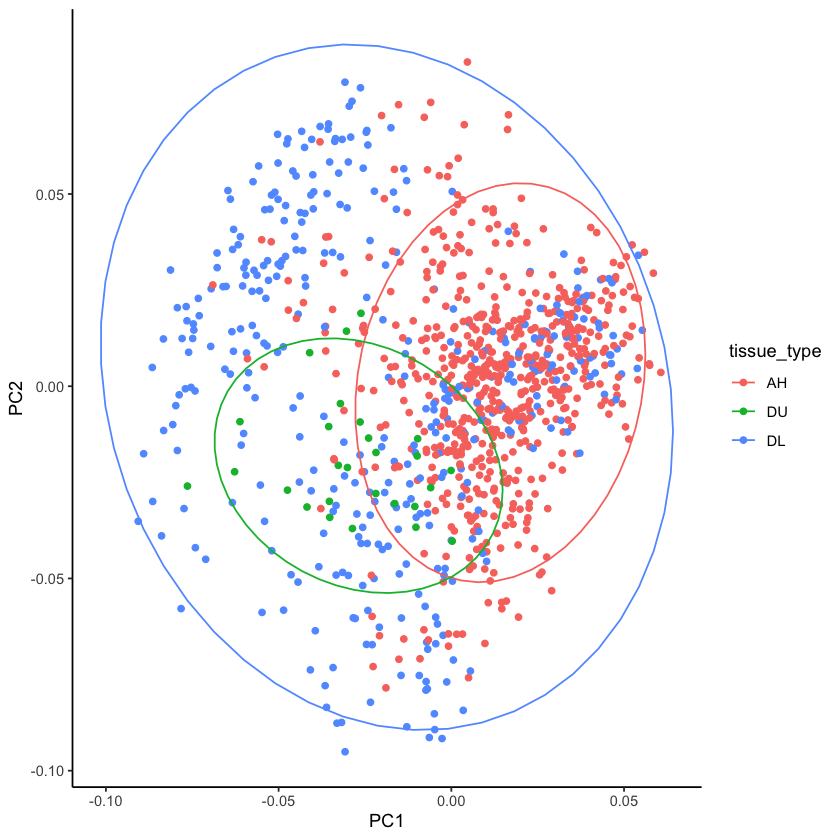

In [101]:
ord_Aq$data$Vectors %>%
left_join(sample_info_tab_16S)  %>%
ggplot(aes(x=PC1, y=PC2, color=tissue_type),  inherit.aes = FALSE ) +
geom_point() +
stat_ellipse() +
theme_classic()

Joining, by = "SampleID"
Joining, by = "SampleID"


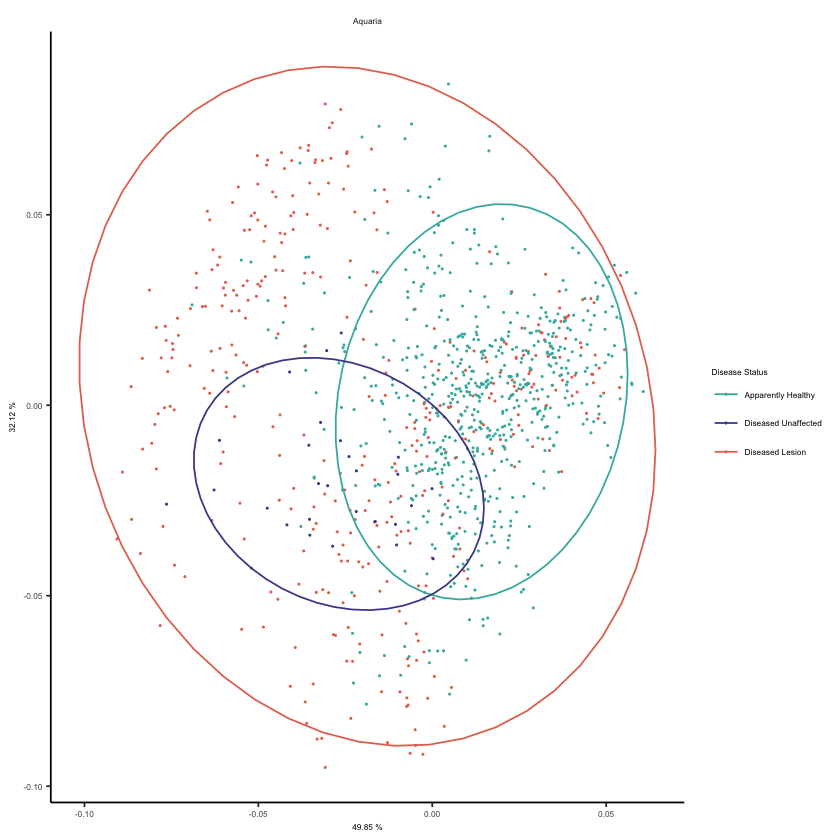

Joining, by = "SampleID"


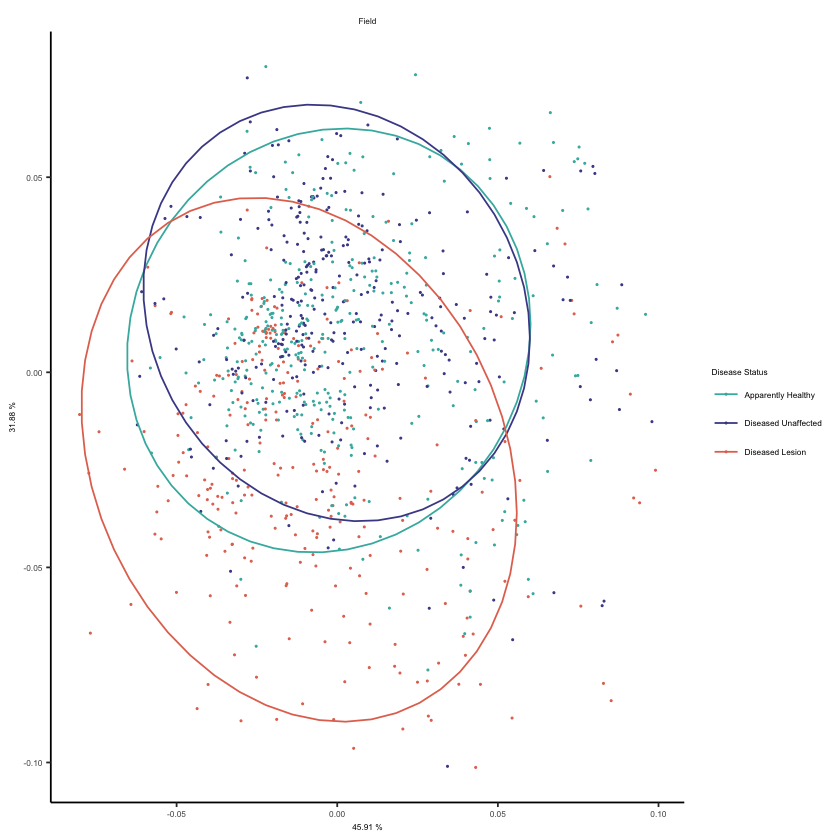

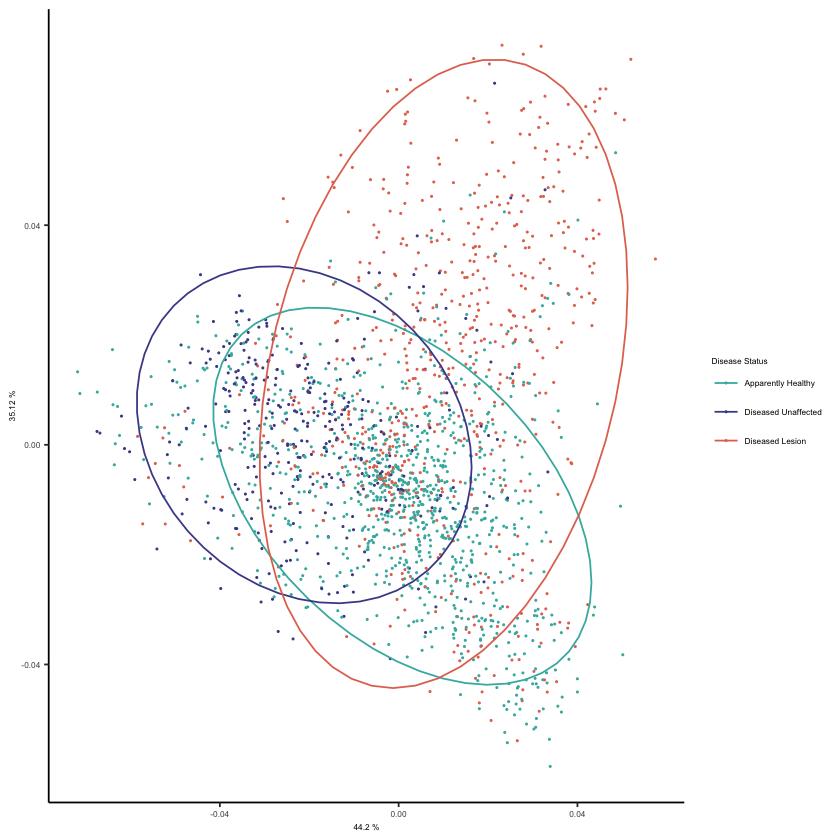

In [169]:
sample_info_tab_16S$tissue_type <- factor(sample_info_tab_16S$tissue_type, 
    levels = c("AH", "DU", "DL"))

fig_aquria= ord_Aq$data$Vectors %>%
left_join(sample_info_tab_16S)  %>%
ggplot(aes(x=PC1, y=PC2, color=tissue_type),  inherit.aes = FALSE ) +
geom_point(size=.2) +
stat_ellipse() +
theme_classic() +
xlab(paste(round(100*ord_Aq$data$ProportionExplained[1],2),"%")) +
  ylab(paste(round(100*ord_Aq$data$ProportionExplained[2],2),"%")) +
scale_color_manual(values=c("#40B5AD", "#4a4a96", "#E3735E"),
                  labels=c(AH="Apparently Healthy",
                            DU="Diseased Unaffected", 
                            DL="Diseased Lesion")) +
theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=5)) +
theme(axis.title.x = element_text(size = 5)) +
theme(axis.title.y = element_text(size = 5)) +
theme(axis.text.x = element_text(size =5)) +
theme(axis.text.y = element_text(size =5)) +
theme(strip.text.x = element_text(size =5)) +
theme(strip.text.x = element_text(size =5),
strip.background = element_blank()) +
labs(color="Disease Status") +
facet_grid(.~Biome)

fig_aquria



fig_field=ord_Fi$data$Vectors %>%
left_join(sample_info_tab_16S)  %>%
ggplot(aes(x=PC1, y=PC2, color=tissue_type),  inherit.aes = FALSE ) +
geom_point(size=.2) +
stat_ellipse() +
theme_classic() +
xlab(paste(round(100*ord_Fi$data$ProportionExplained[1],2),"%")) +
  ylab(paste(round(100*ord_Fi$data$ProportionExplained[2],2),"%")) +
scale_color_manual(values=c("#40B5AD", "#4a4a96", "#E3735E"),
                  labels=c(AH="Apparently Healthy",
                            DU="Diseased Unaffected", 
                            DL="Diseased Lesion")) +
theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=5)) +
theme(axis.title.x = element_text(size = 5)) +
theme(axis.title.y = element_text(size = 5)) +
theme(axis.text.x = element_text(size =5)) +
theme(axis.text.y = element_text(size =5)) +
theme(strip.text.x = element_text(size =5),
strip.background = element_blank()) +
facet_grid(.~Biome) +
labs(color="Disease Status")
fig_field


fig_both=ord_both$data$Vectors %>%
left_join(sample_info_tab_16S)  %>%
ggplot(aes(x=PC1, y=PC2, color=tissue_type),  inherit.aes = FALSE ) +
geom_point(size=.2) +
stat_ellipse() +
theme_classic() +
xlab(paste(round(100*ord_both$data$ProportionExplained[1],2),"%")) +
  ylab(paste(round(100*ord_both$data$ProportionExplained[2],2),"%")) +
scale_color_manual(values=c("#40B5AD", "#4a4a96", "#E3735E"),
                  labels=c(AH="Apparently Healthy",
                            DU="Diseased Unaffected", 
                            DL="Diseased Lesion")) +
theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=5)) +
theme(axis.title.x = element_text(size = 5)) +
theme(axis.title.y = element_text(size = 5)) +
theme(axis.text.x = element_text(size =5)) +
theme(axis.text.y = element_text(size =5)) +
theme(strip.text.x = element_text(size =5),
strip.background = element_blank()) +
labs(color="Disease Status")
fig_both

In [ ]:
sum_ps.coral   <- ps.coral  %>%
  #tax_glom(taxrank = "") %>%
  transform_sample_counts(function(x) {x/sum(x)} ) %>% # Transform to rel. abundance
  psmelt()

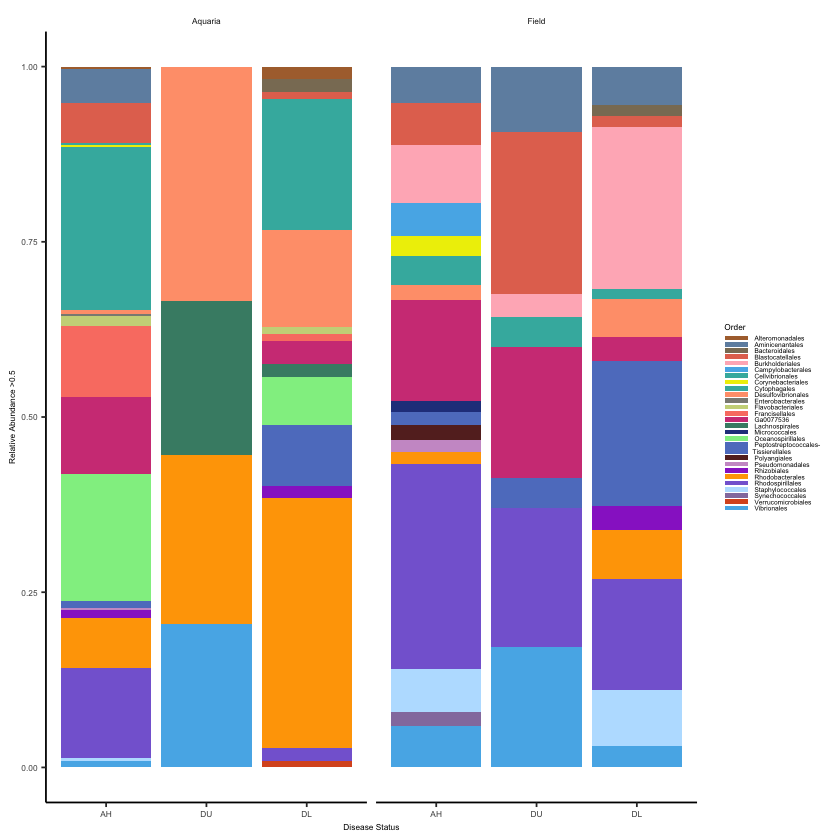

In [165]:
sum_ps.coral$tissue_type <- factor(sum_ps.coral$tissue_type, 
    levels = c("AH","DU", "DL"))
ra_tissue = sum_ps.coral %>%
filter(Abundance>0.5 ) %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__", 
                replacement = "")  %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "Peptostreptococcales-Tissierellales", 
                replacement = "Peptostreptococcales-\nTissierellales")  %>%
ggplot( 
       aes(x =tissue_type, y=Abundance, fill=Order)) + 
geom_bar(stat="identity", position="fill") +
facet_grid(tissue_type~., scales = "free") +
theme_classic() +
scale_fill_manual(values=c(
 "#AD6F3B",
"#6F8FAF",                        
 "#8A7C64",
 "#E3735E",                       
 "lightpink",
 "#56B4E9",
"#40B5AD",
"yellow2",
 "#40B5AD",
"lightsalmon",
 "ivory4",
"#CBD588",
 "salmon",
"#D14285",
"aquamarine4",
"royalblue4",
"lightgreen",
"#5F7FC7",
 "#652926",
"#CD9BCD",
 "darkorchid",
 "orange",
"#8569D5",
"#bae1ff",
 "#957DAD",
"#DA5724",
"#56B4E9",                      
 "#AD6F3B",
 "#8A7C64",
"#E3735E",
 "#56B4E9",
"yellow2",
 "#673770",
"lightsalmon",
 "ivory4",
"#CBD588",
 "salmon",
"#D14285",
"aquamarine4",
"royalblue4",
"lightgreen",
"#5F7FC7",
 "#652926",
"#CD9BCD",
 "darkorchid")) +
guides(fill = guide_legend(keywidth = 1, , keyheight =.25, ncol=1)) +
#theme(axis.text.x = element_text(angle = 20, hjust = 1)) +
ylab("Relative Abundance >0.5") +
xlab("Disease Status") +
scale_x_discrete(labels=c("Mucus" = "Mucus", "TissueSlurry" = " Tissue Slurry",
                              "TissueSlurry_Skeleton" = "Tissue Slurry Skeleton")) +
theme(legend.text =element_text(size=4)) +
theme(legend.title = element_text(size=5)) +
theme(axis.title.x = element_text(size = 5)) +
theme(axis.title.y = element_text(size = 5)) +
theme(axis.text.x = element_text(size =5)) +
theme(axis.text.y = element_text(size =5)) +
theme(strip.text.x = element_text(size =5),
strip.background = element_blank()) +
facet_grid(.~Biome, scale = "free")
ra_tissue

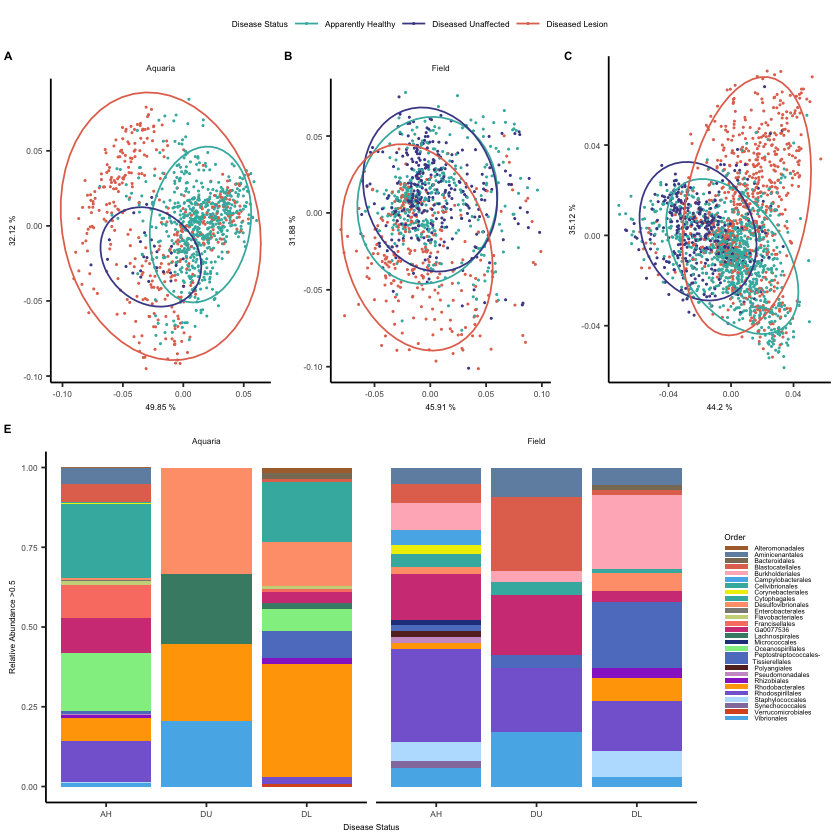

In [171]:
top = ggpubr::ggarrange(fig_aquria, fig_field, fig_both, labels = c("A", "B", "C"), common.legend = TRUE, 
                  font.label = list(size = 7, color = "black"), nrow =1)
bottom = ggpubr::ggarrange(ra_tissue, labels = c("E"),
                  font.label = list(size = 7, color = "black"))
ggpubr::ggarrange(top, bottom,  nrow =2)

ggsave("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/figs/ord_ra.png",
     width = 4, height = 4, units = "in", dpi=300)

Joining, by = "SampleID"
Joining, by = "FeatureID"
Joining, by = "FeatureID"


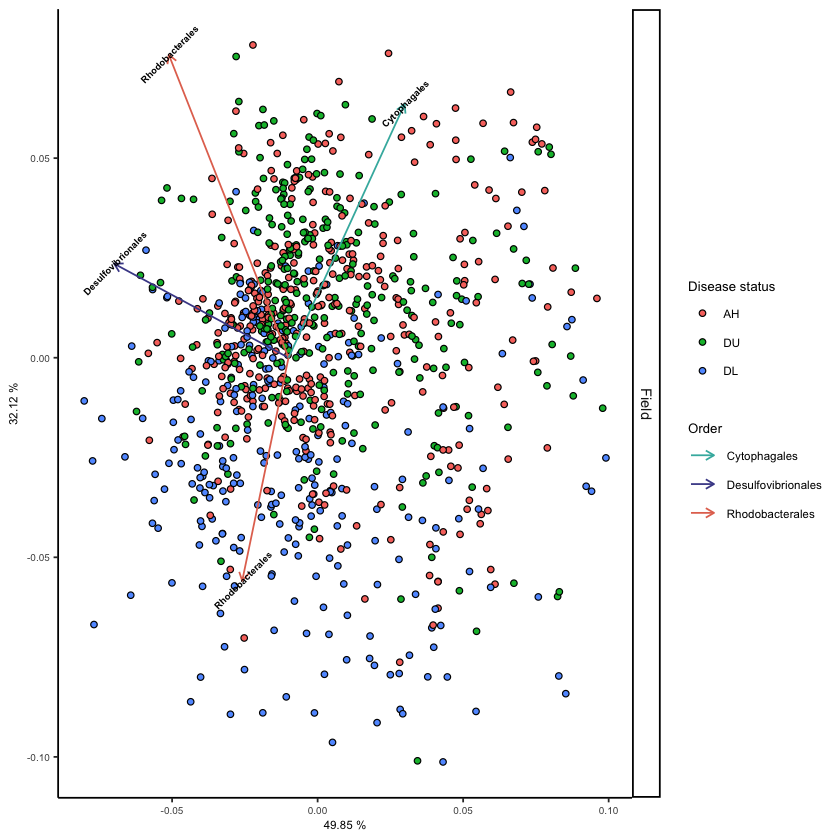

In [122]:
#create the base plot with only the arrows
baseplot_F<- 
ord_Aq$data$Vectors %>%
ggplot() +
  geom_point(aes(x=PC1, y=PC2, fill=tissue_type),
    data=ord_Fi$data$Vectors %>%
      left_join(sample_info_tab_16S),
      shape=21
      ) 

fig_aquria = baseplot_F +

  xlab(paste(round(100*ord_Aq$data$ProportionExplained[1],2),"%")) +
  ylab(paste(round(100*ord_Aq$data$ProportionExplained[2],2),"%")) +
  geom_segment(data=ord_Aq$data$Species %>% 
                 mutate(a=sqrt(PC1^2+PC2^2)) %>% # calculate the distance from the origin
                 top_n(4, a) %>% #keep 8 furthest away points
                 mutate(PC1=PC1*0.3, PC2=PC2*0.3) %>% # scale arrows linearly... is this ok? 
                 left_join(taxtable_16S)%>%
               mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "Peptostreptococcales-Tissierellales", 
                replacement = "Peptostreptococcales-\nTissierellales"),
             

aes(x=-0.01, xend=PC1, y=0, yend=PC2, 
                   color=Order
                  ),
               
               arrow = arrow(length = unit(0.2,"cm"))
              ) +
geom_text(data = ord_Aq$data$Species%>% 
                 mutate(a=sqrt(PC1^2+PC2^2)) %>% # calculate the distance from the origin
                 top_n(4, a) %>% #keep 8 furthest away points
        
                 mutate(PC1=PC1*0.3, PC2=PC2*0.3) %>% # scale arrows linearly... is this ok? 
                 left_join(taxtable_16S), aes(x = PC1, y = PC2, label = Order),size=2, nudge_x = 0,
          nudge_y = 0.0,
         fontface = "bold",
         angle = 45)  +


scale_color_manual(values=c("#40B5AD", "#4a4a96", "#E3735E"),
                  labels=c(AH="Apparently Healthy",
                            DU="Diseased Unaffected", 
                            DL="Diseased Lesion")) +

theme_classic() +
theme(legend.text =element_text(size=7)) +
theme(legend.title = element_text(size=8)) +
theme(axis.title.x = element_text(size = 7)) +
theme(axis.title.y = element_text(size = 7)) +
theme(axis.text.x = element_text(size =6)) +
theme(axis.text.y = element_text(size =6)) +
labs(fill='Disease status', color="Order") +
facet_grid(Biome~.)
fig_aquria

Joining, by = "SampleID"
Joining, by = "FeatureID"
Joining, by = "FeatureID"


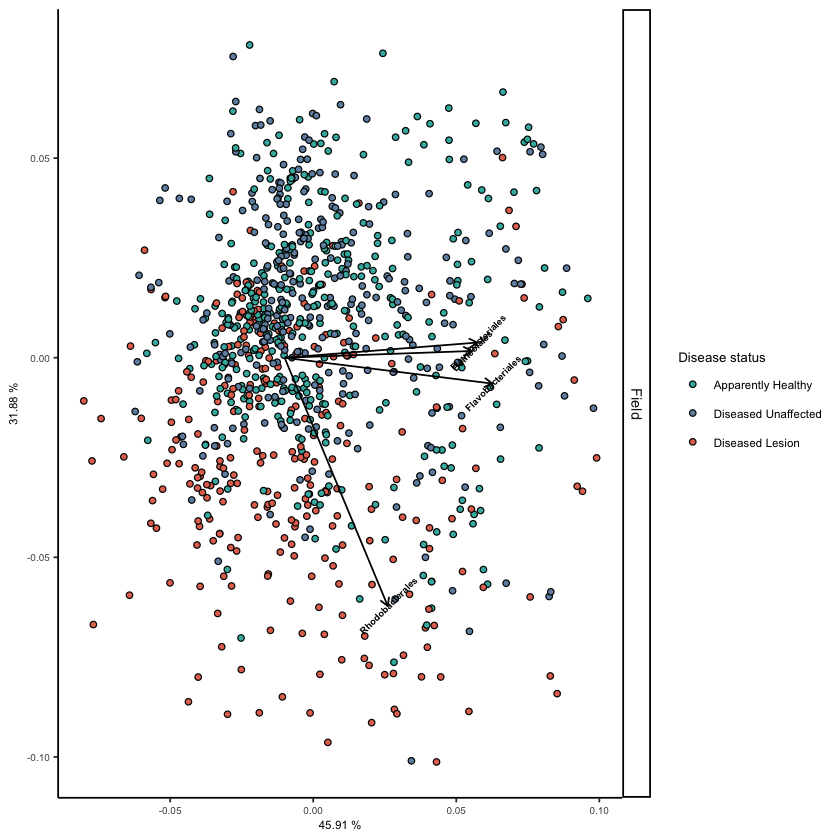

In [126]:
#create the base plot with only the arrows



# now overlay samples
baseplot_F<- 
ggplot() +
  geom_point(aes(x=PC1, y=PC2, fill=tissue_type),
    data=ord_Fi$data$Vectors %>%
      left_join(sample_info_tab_16S),
      shape=21
      ) 

fig_field = baseplot_F +

theme_classic() +
  xlab(paste(round(100*ord_Fi$data$ProportionExplained[1],2),"%")) +
  ylab(paste(round(100*ord_Fi$data$ProportionExplained[2],2),"%")) +
  geom_segment(data=ord_Fi$data$Species %>% 
                 mutate(a=sqrt(PC1^2+PC2^2)) %>% # calculate the distance from the origin
                 top_n(4, a) %>% #keep 8 furthest away points
                 mutate(PC1=PC1*0.3, PC2=PC2*0.3) %>% # scale arrows linearly... is this ok? 
                 left_join(taxtable_16S)%>%
               mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "Peptostreptococcales-Tissierellales", 
                replacement = "Peptostreptococcales-\nTissierellales"),
             

aes(x=-0.01, xend=PC1, y=0, yend=PC2, 
                   #color=Order
                  ),
               
               arrow = arrow(length = unit(0.2,"cm"))
              ) +
geom_text(data = ord_Fi$data$Species%>% 
                 mutate(a=sqrt(PC1^2+PC2^2)) %>% # calculate the distance from the origin
                 top_n(4, a) %>% #keep 8 furthest away points
        
                 mutate(PC1=PC1*0.3, PC2=PC2*0.3) %>% # scale arrows linearly... is this ok? 
                 left_join(taxtable_16S), aes(x = PC1, y = PC2, label = Order),size=2, nudge_x = 0,
          nudge_y = 0.0,
         fontface = "bold",
         angle = 45)  +


scale_fill_manual(values=c("#40B5AD", "#6F8FAF", "#E3735E"),
                  labels=c(AH="Apparently Healthy",
                            DU="Diseased Unaffected", 
                            DL="Diseased Lesion")) +

theme_classic() +
theme(legend.text =element_text(size=7)) +
theme(legend.title = element_text(size=8)) +
theme(axis.title.x = element_text(size = 7)) +
theme(axis.title.y = element_text(size = 7)) +
theme(axis.text.x = element_text(size =6)) +
theme(axis.text.y = element_text(size =6)) +
labs(fill='Disease status', color="Order") +
facet_grid(Biome~.)
fig_field

Joining, by = "SampleID"
Joining, by = "FeatureID"
Joining, by = "FeatureID"


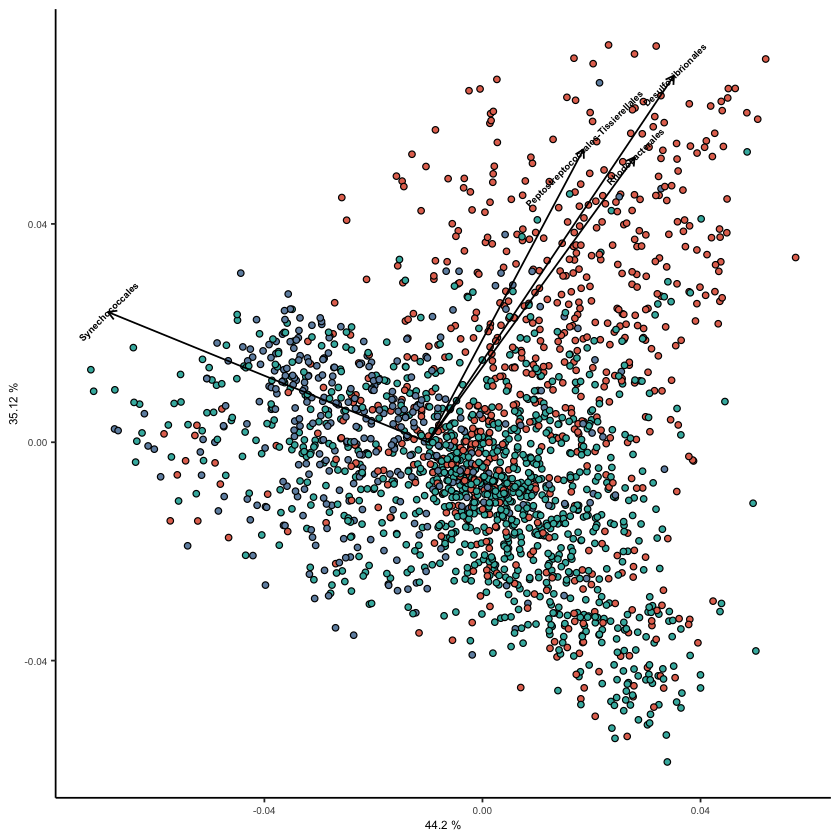

In [127]:
#create the base plot with only the arrows


# now overlay samples
baseplot_F<- 
ggplot() +
  geom_point(aes(x=PC1, y=PC2, fill=tissue_type),
    data=ord_both$data$Vectors %>%
      left_join(sample_info_tab_16S),
      shape=21
      )  


fig_both = baseplot_F +

theme_classic() +
  xlab(paste(round(100*ord_both$data$ProportionExplained[1],2),"%")) +
  ylab(paste(round(100*ord_both$data$ProportionExplained[2],2),"%")) +
  geom_segment(data=ord_both$data$Species %>% 
                 mutate(a=sqrt(PC1^2+PC2^2)) %>% # calculate the distance from the origin
                 top_n(4, a) %>% #keep 8 furthest away points
                 mutate(PC1=PC1*0.3, PC2=PC2*0.3) %>% # scale arrows linearly... is this ok? 
                 left_join(taxtable_16S)%>%
               mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "Peptostreptococcales-Tissierellales", 
                replacement = "Peptostreptococcales-\nTissierellales"),
             

aes(x=-0.01, xend=PC1, y=0, yend=PC2, 
                   #color=Order
                  ),
               
               arrow = arrow(length = unit(0.2,"cm"))
              ) +
geom_text(data = ord_both$data$Species%>% 
                 mutate(a=sqrt(PC1^2+PC2^2)) %>% # calculate the distance from the origin
                 top_n(4, a) %>% #keep 8 furthest away points
        
                 mutate(PC1=PC1*0.3, PC2=PC2*0.3) %>% # scale arrows linearly... is this ok? 
                 left_join(taxtable_16S), aes(x = PC1, y = PC2, label = Order),size=2,
          
         fontface = "bold",
         angle = 45)  +


scale_fill_manual(values=c("#40B5AD", "#6F8FAF", "#E3735E"),
                  labels=c(AH="Apparently Healthy",
                            DU="Diseased Unaffected", 
                            DL="Diseased Lesion")) +

theme_classic() +
theme(legend.text =element_text(size=7)) +
theme(legend.title = element_text(size=8)) +
theme(axis.title.x = element_text(size = 7)) +
theme(axis.title.y = element_text(size = 7)) +
theme(axis.text.x = element_text(size =6)) +
theme(axis.text.y = element_text(size =6)) +
labs(fill='Disease status', color="Order") +
theme(legend.position = "none",
    panel.grid.minor.x = element_blank()) 
fig_both

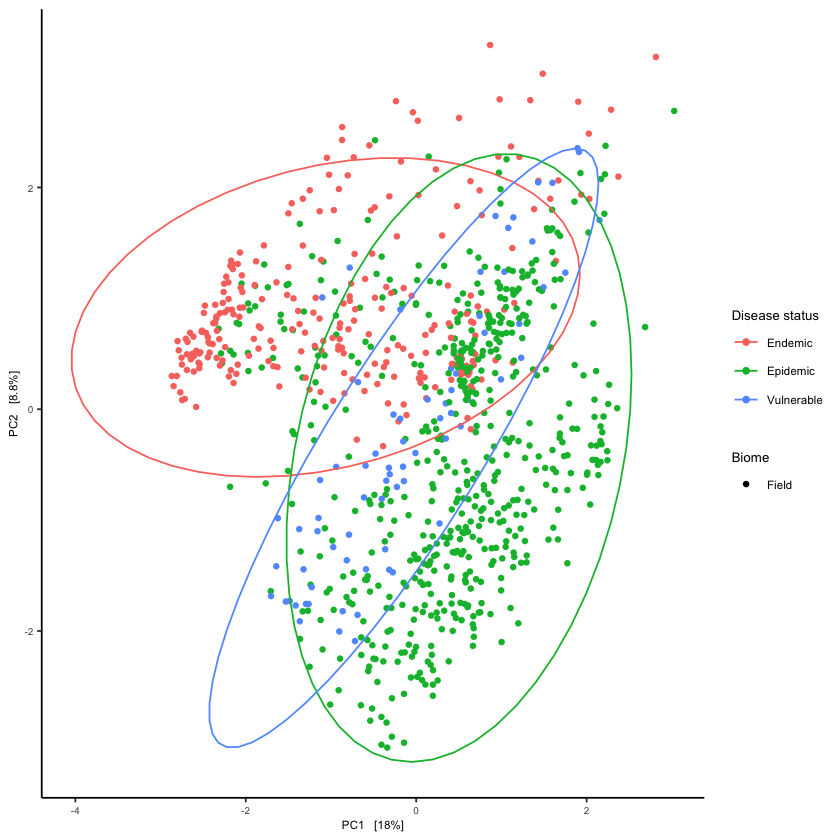

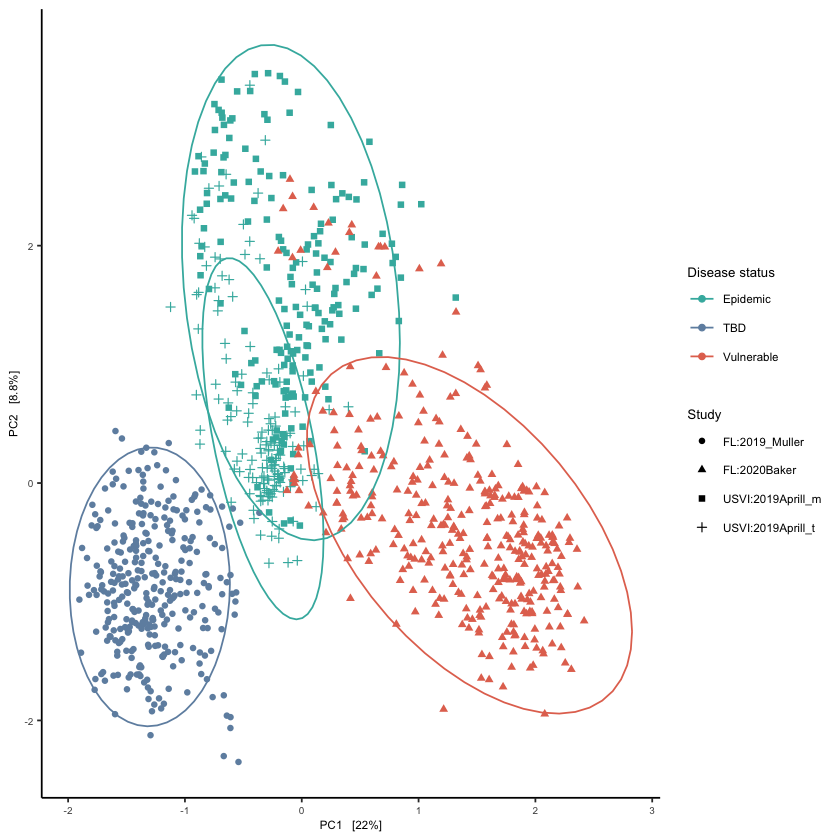

In [128]:
plot_ordination(ps.coral_TL_reef_CLR, ps.coral_TL_reef_ord,
                               color="SCTLD_status",
                                shape="Biome",
                               axes = c(1,2)) +
theme_classic() +
theme(legend.text =element_text(size=6),
     legend.title=element_text(size=7)) +
theme(axis.title.x = element_text(size = 7)) +
theme(axis.title.y = element_text(size = 7)) +
theme(axis.text.x = element_text(size =6)) +
theme(axis.text.y = element_text(size =6)) +
#scale_color_manual(values=c("#40B5AD", "#6F8FAF", "#E3735E")) +
stat_ellipse() +
theme_classic() +
theme(legend.text =element_text(size=7)) +
theme(legend.title = element_text(size=8)) +
theme(axis.title.x = element_text(size = 7)) +
theme(axis.title.y = element_text(size = 7)) +
theme(axis.text.x = element_text(size =6)) +
theme(axis.text.y = element_text(size =6)) +
labs(color='Disease status')


plot_ordination(ps.coral_TL_meso_CLR, ps.coral_TL_meso_ord,
                               color="SCTLD_status",
                                shape="Study",
                               axes = c(1,2)) +
theme_classic() +
theme(legend.text =element_text(size=6),
     legend.title=element_text(size=7)) +
theme(axis.title.x = element_text(size = 7)) +
theme(axis.title.y = element_text(size = 7)) +
theme(axis.text.x = element_text(size =6)) +
theme(axis.text.y = element_text(size =6)) +
scale_color_manual(values=c("#40B5AD", "#6F8FAF", "#E3735E")) +
stat_ellipse() +
theme_classic() +
theme(legend.text =element_text(size=7)) +
theme(legend.title = element_text(size=8)) +
theme(axis.title.x = element_text(size = 7)) +
theme(axis.title.y = element_text(size = 7)) +
theme(axis.text.x = element_text(size =6)) +
theme(axis.text.y = element_text(size =6)) +
labs(color='Disease status')

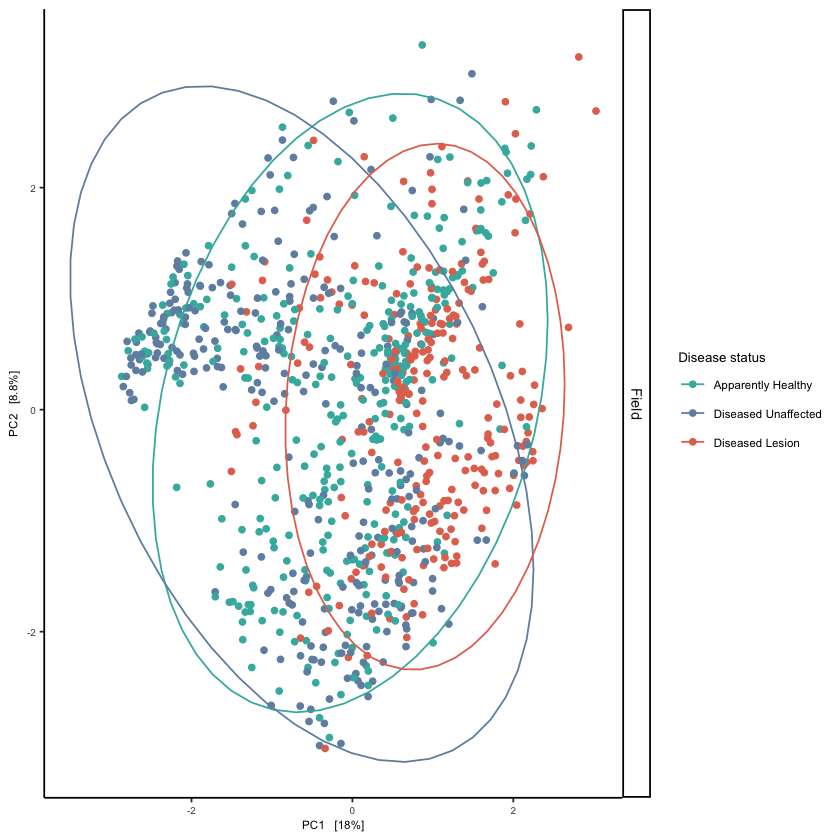

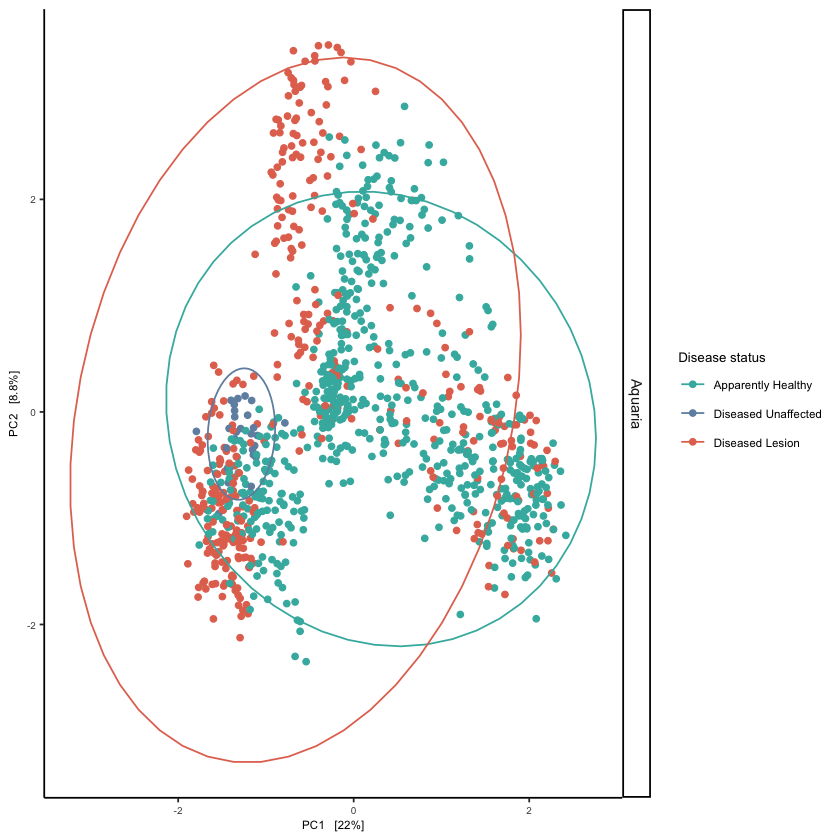

In [129]:
sample_data(ps.coral_TL_reef_CLR)$tissue_type = factor(sample_data(ps.coral_TL_reef_CLR)$tissue_type,
                                  c("AH", "DU", "DL")) 

ord_field= plot_ordination(ps.coral_TL_reef_CLR, ps.coral_TL_reef_ord,
                               color="tissue_type",
                              
                               axes = c(1,2)) +
theme_classic() +
theme(legend.text =element_text(size=6),
     legend.title=element_text(size=7)) +
theme(axis.title.x = element_text(size = 7)) +
theme(axis.title.y = element_text(size = 7)) +
theme(axis.text.x = element_text(size =6)) +
theme(axis.text.y = element_text(size =6)) +
scale_color_manual(values=c("#40B5AD", "#6F8FAF", "#E3735E"),
                  labels=c(AH="Apparently Healthy",
                            DU="Diseased Unaffected", 
                            DL="Diseased Lesion")) +
stat_ellipse() +
theme_classic() +
theme(legend.text =element_text(size=7)) +
theme(legend.title = element_text(size=8)) +
theme(axis.title.x = element_text(size = 7)) +
theme(axis.title.y = element_text(size = 7)) +
theme(axis.text.x = element_text(size =6)) +
theme(axis.text.y = element_text(size =6)) +
labs(color='Disease status') +
facet_grid(Biome~.)
ord_field

 sample_data(ps.coral_TL_meso_CLR)$tissue_type = factor(sample_data(ps.coral_TL_meso_CLR)$tissue_type,
                                  c("AH", "DU", "DL")) 

ord_aquria=plot_ordination(ps.coral_TL_meso_CLR, ps.coral_TL_meso_ord,
                               color="tissue_type",
                            
                               axes = c(1,2)) +
theme_classic() +
theme(legend.text =element_text(size=6),
     legend.title=element_text(size=7)) +
theme(axis.title.x = element_text(size = 7)) +
theme(axis.title.y = element_text(size = 7)) +
theme(axis.text.x = element_text(size =6)) +
theme(axis.text.y = element_text(size =6)) +
scale_color_manual(values=c("#40B5AD", "#6F8FAF", "#E3735E"),
                  labels=c(AH="Apparently Healthy",
                            DU="Diseased Unaffected", 
                            DL="Diseased Lesion")) +
stat_ellipse() +
theme_classic() +
theme(legend.text =element_text(size=7)) +
theme(legend.title = element_text(size=8)) +
theme(axis.title.x = element_text(size = 7)) +
theme(axis.title.y = element_text(size = 7)) +
theme(axis.text.x = element_text(size =6)) +
theme(axis.text.y = element_text(size =6)) +
labs(color='Disease status') +
facet_grid(Biome~.)

ord_aquria

In [ ]:
sample_data(ps.coral_clr)$tissue_type = factor(sample_data(ps.coral_clr)$tissue_type,
                                  c("AH", "DU", "DL")) 

ord_tissue=plot_ordination(ps.coral_clr, ps.coral_clr.ord,

                               color="tissue_type",
                               axes = c(1,2)) +
theme_classic() +
theme(legend.text =element_text(size=6),
     legend.title=element_text(size=7)) +
theme(axis.title.x = element_text(size = 7)) +
theme(axis.title.y = element_text(size = 7)) +
theme(axis.text.x = element_text(size =6)) +
theme(axis.text.y = element_text(size =6)) +
scale_color_manual(values=c("#40B5AD", "#6F8FAF", "#E3735E"),
                  labels=c(AH="Apparently Healthy",
                            DU="Diseased Unaffected", 
                            DL="Diseased Lesion")) +
 
stat_ellipse() +
theme_classic() +
#theme(legend.text =element_text(size=7)) +
#theme(legend.title = element_text(size=8)) +
theme(axis.title.x = element_text(size = 7)) +
theme(axis.title.y = element_text(size = 7)) +
theme(axis.text.x = element_text(size =6)) +
theme(axis.text.y = element_text(size =6)) +
labs(color='Disease status') +
theme(legend.position = "none",
    panel.grid.minor.x = element_blank()) 


ord_tissue

In [131]:
sum_ps.coral   <- ps.coral  %>%
  #tax_glom(taxrank = "") %>%
  transform_sample_counts(function(x) {x/sum(x)} ) %>% # Transform to rel. abundance
  psmelt()

In [ ]:
sum_ps.coral$tissue_type <- factor(sum_ps.coral$tissue_type, 
    levels = c("AH","DU", "DL"))
ra_tissue = sum_ps.coral %>%
filter(Abundance>0.5 ) %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__", 
                replacement = "")  %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "Peptostreptococcales-Tissierellales", 
                replacement = "Peptostreptococcales-\nTissierellales")  %>%
ggplot( 
       aes(x =Biome, y=Abundance, fill=Order)) + 
geom_bar(stat="identity", position="fill") +
facet_grid(tissue_type~., scales = "free") +
theme_classic() +
scale_fill_manual(values=c(
 "#AD6F3B",
"#6F8FAF",                        
 "#8A7C64",
 "#E3735E",                       
 "lightpink",
 "#56B4E9",
"#40B5AD",
"yellow2",
 "#40B5AD",
"lightsalmon",
 "ivory4",
"#CBD588",
 "salmon",
"#D14285",
"aquamarine4",
"royalblue4",
"lightgreen",
"#5F7FC7",
 "#652926",
"#CD9BCD",
 "darkorchid",
 "orange",
"#8569D5",
"#bae1ff",
 "#957DAD",
"#DA5724",
"#56B4E9",                      
 "#AD6F3B",
 "#8A7C64",
"#E3735E",
 "#56B4E9",
"yellow2",
 "#673770",
"lightsalmon",
 "ivory4",
"#CBD588",
 "salmon",
"#D14285",
"aquamarine4",
"royalblue4",
"lightgreen",
"#5F7FC7",
 "#652926",
"#CD9BCD",
 "darkorchid")) +
guides(fill = guide_legend(keywidth = 0.5, , keyheight =.40, ncol=1)) +
theme(axis.text.x = element_text(angle = 20, hjust = 1)) +
ylab("Relative Abundance >0.35") +
xlab("Biome") +
scale_x_discrete(labels=c("Mucus" = "Mucus", "TissueSlurry" = " Tissue Slurry",
                              "TissueSlurry_Skeleton" = "Tissue Slurry Skeleton")) +
theme(legend.text =element_text(size=6)) +
theme(legend.title = element_text(size=6)) +
theme(axis.title.x = element_text(size = 6)) +
theme(axis.title.y = element_text(size = 6)) +
theme(axis.text.x = element_text(size =5)) +
theme(axis.text.y = element_text(size =5)) +
theme(strip.text.x = element_text(size =5)) 
ra_tissue
#ggsave("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/figs/RA.png",
 #       width = 6, height = 7, units = "in", dpi=250)

In [ ]:
?ggpubr::ggarrange

In [ ]:
top 

In [ ]:
top = ggpubr::ggarrange(fig_aquria, fig_field, labels = c("A", "B"), common.legend = TRUE, 
                  font.label = list(size = 9, color = "black"))
bottom = ggpubr::ggarrange(fig_both, ra_tissue, labels = c( "C", "D"),
                  font.label = list(size = 9, color = "black"))
ggpubr::ggarrange(top, bottom,  nrow =2)

ggsave("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/figs/ord_ra.png",
     width = 6, height = 6, units = "in", dpi=300)

In [ ]:
ord_region = plot_ordination(ps.coral_clr, ps.coral_clr.ord,
                               color="country",
                               shape="tissue_type",
                               axes = c(1,2)) +
theme_classic() +
scale_color_manual(values=c("#bae1ff", "#957DAD", "lightsalmon",  
                           
                           "#F9D4A4", 
                            "#89C4C2",
                        
                           "gray80", 
                           "#D1A33D",
                           "lightblue4", "lightpink", "ivory4","royalblue4", "darkorchid", 
                           "palevioletred1", "#56B4E9","#CBD588","yellow2","#5F7FC7", "orange","#DA5724",
                            "gray80",
                           "#AD6F3B", "#673770")) +
theme(legend.text =element_text(size=4)) +
theme(legend.title = element_text(size=5)) +
theme(axis.title.x = element_text(size = 7)) +
theme(axis.title.y = element_text(size = 7)) +
theme(axis.text.x = element_text(size =6)) +
theme(axis.text.y = element_text(size =6))



#stat_ellipse()
ord_region

In [ ]:
ord_biome = plot_ordination(ps.coral_clr, ps.coral_clr.ord,
                               color="Biome",
                               shape="tissue_type",
                               axes = c(1,2)) +
theme_classic() +
scale_color_manual(values=c("#ffb3ba", "#bae1ff", "#957DAD", "lightsalmon",  
                           
                           "#F9D4A4", 
                            "#89C4C2",
                        
                           "gray80", 
                           "#D1A33D",
                           "lightblue4", "lightpink", "ivory4","royalblue4", "darkorchid", 
                           "palevioletred1", "#56B4E9","#CBD588","yellow2","#5F7FC7", "orange","#DA5724",
                            "gray80",
                           "#AD6F3B", "#673770")) +
theme(legend.text =element_text(size=4)) +
theme(legend.title = element_text(size=5)) +
theme(axis.title.x = element_text(size = 7)) +
theme(axis.title.y = element_text(size = 7)) +
theme(axis.text.x = element_text(size =6)) +
theme(axis.text.y = element_text(size =6))



#stat_ellipse()
ord_biome

In [ ]:





ord_primer= plot_ordination(ps.coral_clr, ps.coral_clr.ord,
                               color="primer_names",
                               axes = c(1,2)) +

theme_classic() +
scale_color_manual(values=c( 
                           
                           "#F9D4A4", 
                            "#89C4C2",
                        
                           "gray1", 
                           "#D1A33D",
                           "lightblue4", "lightpink", "ivory4","royalblue4", "darkorchid", 
                           "palevioletred1", "#56B4E9","#CBD588","yellow2","#5F7FC7", "orange","#DA5724",
                            "gray80",
                           "#AD6F3B", "#673770")) +
theme(legend.text =element_text(size=4)) +
theme(legend.title = element_text(size=5)) +
theme(axis.title.x = element_text(size = 7)) +
theme(axis.title.y = element_text(size = 7)) +
theme(axis.text.x = element_text(size =6)) +
theme(axis.text.y = element_text(size =6))

ord_primer

In [ ]:
ord_species=plot_ordination(ps.coral_clr, ps.coral_clr.ord,
                               color="species_code",
                              shape="tissue_type", axes = c(1,2)) +
theme_classic() +
scale_color_manual(values=c("#ffb3ba", "#bae1ff", "#957DAD", "lightsalmon",  
                           
                           "#F9D4A4", 
                            "#89C4C2",
                        
                           "gray80", 
                           "#D1A33D",
                           "lightblue4", "lightpink", "ivory4","royalblue4", "darkorchid", 
                           "palevioletred1", "#56B4E9","#CBD588","yellow2","#5F7FC7", "orange","#DA5724",
                            "gray80",
                           "#AD6F3B", "#673770")) +
theme(legend.text =element_text(size=4)) +
theme(legend.title = element_text(size=5)) +
theme(axis.title.x = element_text(size = 7)) +
theme(axis.title.y = element_text(size = 7)) +
theme(axis.text.x = element_text(size =6)) +
theme(axis.text.y = element_text(size =6))

ord_species

In [ ]:

ord_tissue=plot_ordination(ps.coral_clr, ps.coral_clr.ord,

                               color="tissue_type",
                               axes = c(1,2)) +
theme_classic() +
theme(legend.text =element_text(size=4)) +
theme(legend.title = element_text(size=5)) +
theme(axis.title.x = element_text(size = 7)) +
theme(axis.title.y = element_text(size = 7)) +
theme(axis.text.x = element_text(size =6)) +
theme(axis.text.y = element_text(size =6))

ord_tissue

In [ ]:
ord_species= plot_ordination(ps.coral_clr, ps.coral_clr.ord,
                               color="species_code",
                               axes = c(1,2)) +
theme_classic() +
theme(legend.text =element_text(size=4)) +
theme(legend.title = element_text(size=5)) +
theme(axis.title.x = element_text(size = 7)) +
theme(axis.title.y = element_text(size = 7)) +
theme(axis.text.x = element_text(size =6)) +
theme(axis.text.y = element_text(size =6)) +

scale_color_manual(values=c("#ffb3ba", "#bae1ff", "#957DAD", "lightsalmon",  
                           
                           "#F9D4A4", 
                            "#89C4C2",
                        
                           "gray80", 
                           "#D1A33D",
                           "lightblue4", "lightpink", "ivory4","royalblue4", "darkorchid", 
                           "palevioletred1", "#56B4E9","#CBD588","yellow2","#5F7FC7", "orange","#DA5724",
                            "gray80",
                           "#AD6F3B", "#673770"))

ord_species

In [ ]:
ord_type= plot_ordination(ps.coral_clr, ps.coral_clr.ord,
                               color="sample_type",
                               axes = c(1,2)) +
theme_classic() +
theme(legend.text =element_text(size=7)) +
theme(legend.title = element_text(size=7)) +
theme(axis.title.x = element_text(size = 7)) +
theme(axis.title.y = element_text(size = 7)) +
theme(axis.text.x = element_text(size =6)) +
theme(axis.text.y = element_text(size =6)) +

scale_color_manual(values=c("#ffb3ba", "#bae1ff", "#957DAD", "lightsalmon",  
                           
                           "#F9D4A4", 
                            "#89C4C2",
                        
                           "gray80", 
                           "#D1A33D",
                           "lightblue4", "lightpink", "ivory4","royalblue4", "darkorchid", 
                           "palevioletred1", "#56B4E9","#CBD588","yellow2","#5F7FC7", "orange","#DA5724",
                            "gray80",
                           "#AD6F3B", "#673770"))

ord_type

In [ ]:
ord_reef=plot_ordination(ps.coral_clr, ps.coral_clr.ord,
                               color="reef_name",
                               axes = c(1,2)) +
theme_classic() +
theme(legend.text =element_text(size=6)) +
theme(legend.title = element_text(size=6)) +
theme(axis.title.x = element_text(size = 7)) +
theme(axis.title.y = element_text(size = 7)) +
theme(axis.text.x = element_text(size =6)) +
theme(axis.text.y = element_text(size =6)) +
scale_color_manual(values=c("#56B4E9",
 "#AD6F3B",
 "#8A7C64",
 "lightpink",
 "#56B4E9",
"yellow2",
 "#673770",
"lightsalmon",
 "ivory4",
"#CBD588",
 "salmon",
"#D14285",
"aquamarine4",
"royalblue4",
"lightgreen",
"#5F7FC7",
 "#652926",
"#CD9BCD",
 "darkorchid",
 "orange",
"#8569D5",
"#bae1ff",
 "#957DAD",
"#DA5724",
"#56B4E9",
 ")


ord_reef

In [ ]:
ord_year = plot_ordination(ps.coral_clr, ps.coral_clr.ord,
                               color="collection_year",
                               axes = c(1,2)) +
theme_classic() +
theme(legend.text =element_text(size=7)) +
theme(legend.title = element_text(size=7)) +
theme(axis.title.x = element_text(size = 7)) +
theme(axis.title.y = element_text(size = 7)) +
theme(axis.text.x = element_text(size =6)) +
theme(axis.text.y = element_text(size =6))

ord_year

In [ ]:
ord_alias= plot_ordination(ps.coral_clr, ps.coral_clr.ord,
                               color="Alias",
                               axes = c(1,2)) +
theme_classic() +
theme(legend.text =element_text(size=7)) +
theme(legend.title = element_text(size=7)) +
theme(axis.title.x = element_text(size = 7)) +
theme(axis.title.y = element_text(size = 7)) +
theme(axis.text.x = element_text(size =6)) +
theme(axis.text.y = element_text(size =6)) +

scale_color_manual(values=c("#56B4E9","#CBD588","#5F7FC7", "orange","#DA5724","#CD9BCD",
                           "gray80", "#AD6F3B", "#673770","#006700","#8569D5", 
                           "#5E738F","#D1A33D", "#8A7C64","lightsalmon","aquamarine4", "#652926",
                           "lightblue4", "lightpink","royalblue4","#D14285",
                           "palevioletred1", "#ffb3ba", "#bae1ff", "#957DAD", "lightsalmon",  
                           
                           "#F9D4A4", 
                            "#89C4C2",
                        
                           "gray80", 
                           "#D1A33D",
                           "lightblue4", "lightpink", "ivory4","royalblue4", "darkorchid", 
                           "palevioletred1", "#56B4E9","#CBD588","yellow2","#5F7FC7", "orange","#DA5724",
                            "gray80",
                           "#AD6F3B", "#673770"))

ord_alias

In [ ]:
ggpubr::ggarrange(ord_primer, ord_species, ord_tissue, ord_type, ord_biome, ord_year, 
                  ord_alias, ord_reef, ord_region, font.label = list(size = 7, color = "black"))
ggsave("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/figs/ord_NOAcer.png",
     width = 15, height = 15, units = "in", dpi=300)